In [ ]:
# default_exp actorcritic.diayn

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#export
import torch.nn.utils as nn_utils
from fastai.torch_basics import *
import torch.nn.functional as F
from fastai.data.all import *
from fastai.basics import *
from dataclasses import field,asdict
from typing import List,Any,Dict,Callable
from collections import deque
import gym
import torch.multiprocessing as mp
from torch.optim import *
from dataclasses import dataclass

from fastrl.data import *
from fastrl.async_data import *
from fastrl.basic_agents import *
from fastrl.learner import *
from fastrl.metrics import *
from fastai.callback.progress import *
from fastrl.ptan_extension import *
from fastrl.actorcritic.sac import *

from torch.distributions import *

if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [ ]:
# hide
import tsensor
from tsensor.analysis import *
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# DIAYN

> Diversity Is All You Need

`DIAYN` extends SAC to create *Skills* that can be used for a single or multiple environments. 
[(Eysenbach et al. 2018) [DIAYN] Diversity Is All You Need](https://arxiv.org/pdf/1802.06070.pdf) covers this in detail.

    The general idea is that Skills should each be as diverse as possible and should not be   tied to a reward function specific to an environment.

Their [project site](https://sites.google.com/view/diayn) shows several *incredible* examples of `DIAYN` finding *Skills* without any reward. The original implementation is in tensorflow and ca be found [here](https://github.com/haarnoja/sac/blob/master/sac/algos/diayn.py)

In [ ]:
# export
class Discriminator(Module):
    "`Module` for storing skills. Receives input (`num_inputs`+`num_actions`) -> `num_skills`."
    def __init__(self, num_inputs,num_actions,num_skills,hidden_dim):
        self.linear1 = nn.Linear(num_inputs+num_skills, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim,num_skills)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state.float()))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [ ]:
class FastExplainer(tsensor.explain):
    def __init__(self,once=True,**kwargs):
        super().__init__(**kwargs)
        store_attr()
        self.happened=False
        
    def __enter__(self):
        if self.happened and self.once:return self
        # print("ON trace", sys._getframe())
        self.tracer = ExplainTensorTracer(self)
        sys.settrace(self.tracer.listener)
        frame = sys._getframe()
        prev = frame.f_back # get block wrapped in "with"
        prev.f_trace = self.tracer.listener
        return self.tracer

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.happened=self.once
        if self.happened: return None
        # print("OFF trace")
        sys.settrace(None)
        # At this point we have already tried to visualize the statement
        # If there was no error, the visualization will look normal
        # but a matrix operation error will show the erroneous operator highlighted.
        # That was artificial execution of the code. Now the VM has executed
        # the statement for real and has found the same exception. Make sure to
        # augment the message with causal information.
        if exc_type is None:
            return
        exc_frame, lib_entry_frame = tensor_lib_entry_frame(exc_traceback)
        if lib_entry_frame is not None or is_interesting_exception(exc_value):
            # print("exception:", exc_value, exc_traceback)
            # traceback.print_tb(exc_traceback, limit=5, file=sys.stdout)
            module, name, filename, line, code = info(exc_frame)
            # print('info', module, name, filename, line, code)
            if code is not None:
                # We've already displayed picture so just augment message
                root, tokens = tsensor.parsing.parse(code)
                if root is not None: # Could be syntax error in statement or code I can't handle
                    offending_expr = None
                    try:
                        root.eval(exc_frame)
                    except tsensor.ast.IncrEvalTrap as e:
                        offending_expr = e.offending_expr
                    augment_exception(exc_value, offending_expr)

In [ ]:
# export
@delegates(SAC)
class DIAYN(SAC):
    def __init__(self,num_inputs,action_space,discriminator:Module=None,num_skills:int=20,
                 find_best_skill_interval:int=10,scale_entropy:float=1,
                 best_skill_n_rollouts:int=10,include_actions:bool=False,
                 learn_p_z:bool=False,add_p_z:bool=True,hidden_size=100,lr=0.003,**kwargs):
        store_attr()
        self.num_inputs=num_inputs+self.num_skills
        self.original_num_inputs=num_inputs
        self.p_z=np.full(self.num_skills,1.0/self.num_skills)
        self.discriminator=Discriminator(self.original_num_inputs,action_space.shape[0],
                                         num_skills,hidden_size)
        
        self.discriminator_optim = Adam(self.discriminator.parameters(), lr=self.lr)

        self.log_p_z_episode=[]
        self.z=0
        self.reset_z()
        
        
#         self.clarifier=FastClarify(hush_errors=False)
        self.clarifier=FastExplainer(once=True)
        
        super().__init__(self.num_inputs,action_space,hidden_size=hidden_size,lr=lr,**kwargs)
        
    def sample_z(self):
        """Samples z from p(z), using probabilities in self._p_z."""
        return np.random.choice(self.num_skills,p=self.p_z)
    
    def reset_z(self): self.z=self.sample_z()
    def __call__(self,s,asl):
        aug_s=self.concat_obs_z(s,self.z)
        return super().__call__(aug_s,asl)
    
    def concat_obs_z(self,obs,z):
        """Concatenates the observation to a one-hot encoding of Z."""
        assert np.isscalar(z)
        if type(obs)==list and len(obs)==1: obs=obs[0]
        if len(obs.shape)==2 and obs.shape[0]==1: obs=obs[0]
            
        z_one_hot=np.zeros(self.num_skills)
        z_one_hot[z]=1
        if type(obs)==Tensor: obs=obs.cpu()
        return torch.FloatTensor(np.hstack([obs,z_one_hot])).reshape(1,-1)
    
    def skill_p(self,skill,next_state):
        unnorm_skill_dist=self.discriminator(next_state).unsqueeze(0)
        skill_p=F.softmax(unnorm_skill_dist)[:,skill]
        return skill_p,unnorm_skill_dist
    
    def discriminator_learn(self,skill,out):
        self.discriminator_optim.zero_grad()
        loss=nn.CrossEntropyLoss()(out,torch.LongTensor([skill]))
        loss.backward()
        self.discriminator_optim.step()
        
    def intrinsic_reward(self,next_state):
        skill_p,disc_out=self.skill_p(self.z,next_state)
        intrinsic_reward=np.log(skill_p.cpu().detach()+1e-8)-np.log(self.p_z[self.z])
#         print(skill_p,self.p_z,intrinsic_reward)
        return intrinsic_reward,disc_out
    
    def update_parameters(self, *yb, learn):
        # Sample a batch from memory
#         state_batch, action_batch, reward_batch, next_state_batch, mask_batch = learn.memory.sample(batch_size=batch_size)
        batch=learn.sample_yb
#         print(batch[0])
#         pprint(batch)
        state_batch=torch.stack([o.state.to(device=default_device()) for o in batch]).float()
        next_state_batch=torch.stack([o.last_state.to(device=default_device()) for o in batch]).float()
        action_batch=torch.stack([o.action.to(device=default_device()) for o in batch]).float()
        reward_batch=torch.stack([o.reward.to(device=default_device()) for o in batch]).float()
        mask_batch=torch.stack([o.done.to(device=default_device()) for o in batch]).float().unsqueeze(1)
        
        
#         print(state_batch.shape,next_state_batch.shape,action_batch.shape,reward_batch.shape,mask_batch.shape)
#         state_batch = torch.FloatTensor(state_batch).to(self.device)
#         next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
#         action_batch = torch.FloatTensor(action_batch).to(self.device)
#         reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
#         mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)
#         with self.clarifier:
        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + (1-mask_batch) * self.gamma * (min_qf_next_target)
        qf1, qf2 = self.critic(state_batch, action_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
        qf1_loss = F.mse_loss(qf1, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf2_loss = F.mse_loss(qf2, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone() # For TensorboardX logs
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha) # For TensorboardX logs


        if self.updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)
        self.updates+=1
#         print(self.updates)
#         print('complete')
        return qf1_loss+ qf2_loss+ policy_loss+ alpha_loss+ alpha_tlogs
    
#     def update_parameters(self, *yb, learn):pass

DIAYN.__doc__="""
`discriminator` is an additional `Module` to calculate z.
`num_skills` is the number of skills/options to learn.
`find_best_skill_interval` is how often to recompute the best skill.
When finding the best skill, `best_skill_n_rollouts` determines how many rollouts to 
do per skill.
`include_actions` determines whether to pass actions to the discriminator.
`add_p_z` determines whether to include $\log{p(z)}$ in the pseudo-reward.
`scale_entropy` is the scaling factor for entropy.

A few explainations of some of the internal fields:

We now have `num_inputs` and `original_num_inputs`. `num_inputs` has the `num_skills` being
added to it. This will then be used by the `SAC` parent in initializing the critic and actor.

`original_num_inputs` will only be used by the `discriminator` now.
"""

In [ ]:
show_doc(DIAYN)

<h2 id="DIAYN" class="doc_header"><code>class</code> <code>DIAYN</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>DIAYN</code>(**`num_inputs`**, **`action_space`**, **`discriminator`**:`Module`=*`None`*, **`num_skills`**:`int`=*`20`*, **`find_best_skill_interval`**:`int`=*`10`*, **`scale_entropy`**:`float`=*`1`*, **`best_skill_n_rollouts`**:`int`=*`10`*, **`include_actions`**:`bool`=*`False`*, **`learn_p_z`**:`bool`=*`False`*, **`add_p_z`**:`bool`=*`True`*, **`hidden_size`**=*`100`*, **`lr`**=*`0.003`*, **`gamma`**=*`0.99`*, **`tau`**=*`0.005`*, **`alpha`**=*`0.2`*, **`policy`**=*`'gaussian'`*, **`automatic_entropy_tuning`**=*`True`*, **`target_update_interval`**=*`1`*) :: [`SAC`](/fast-reinforcement-learning-2/actorcritic.sac.html#SAC)

`discriminator` is an additional `Module` to calculate z.
`num_skills` is the number of skills/options to learn.
`find_best_skill_interval` is how often to recompute the best skill.
When finding the best skill, `best_skill_n_rollouts` determines how many rollouts to 
do per skill.
`include_actions` determines whether to pass actions to the discriminator.
`add_p_z` determines whether to include $\log{p(z)}$ in the pseudo-reward.
`scale_entropy` is the scaling factor for entropy.

A few explainations of some of the internal fields:

We now have `num_inputs` and `original_num_inputs`. `num_inputs` has the `num_skills` being
added to it. This will then be used by the [`SAC`](/fast-reinforcement-learning-2/actorcritic.sac.html#SAC) parent in initializing the critic and actor.

`original_num_inputs` will only be used by the `discriminator` now.

In [ ]:
# export
class DiscriminatorTrainer(ExperienceReplay):

    def __init__(self,*args,**kwargs):
        self.log_p_z_episode=[]
        super().__init__(*args,**kwargs)
        
    def before_fit(self):
        self.learn.agent.warming_up=True
        while len(self.queue)<self.starting_els:
            for i,o in enumerate(self.dls.train):
                z=self.learn.agent.z
                batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(o[0][i],z)[0],
                                           action=o[1][i],
                                           reward=o[2][i],
                                           last_state=self.learn.agent.concat_obs_z(o[3][i],z)[0], 
                                           done=(o[4][i] and self.max_steps!=o[6][i]),
                                           episode_reward=o[5][i],steps=o[6][i])
                                    for i in range(len(o[0]))]
#                 print(self.max_steps,max([o.steps for o in batch]))
#                 print(batch[0])
                for k in range(len(batch)):
                    intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
                    self.learn.agent.discriminator_learn(self.agent.z,disc_out)
                    batch[k]=ExperienceFirstLast(
                        state=batch[k].state.to(device=default_device()),
                        action=batch[k].action,
                        reward=intrinsic_reward,
                        last_state=batch[k].last_state.to(device=default_device()),
                        done=batch[k].done,
                        episode_reward=batch[k].episode_reward,
                        steps=batch[k].steps
                    )


#                 print(batch[0])
                for _b in batch:self.queue.append(_b)
                if any([_b.done for _b in batch]): self.learn.agent.reset_z()
                if len(self.queue)>self.starting_els:break
        self.learn.agent.warming_up=False

# #     def after_epoch(self):
# #         print(len(self.queue))
    def before_batch(self):
#         print(len(self.queue))
        b=list(self.learn.xb)+list(self.learn.yb)
        z=self.learn.agent.z
        batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(b[0][i],z)[0],
                                   action=b[1][i],
                                   reward=b[2][i],
                                   last_state=self.learn.agent.concat_obs_z(b[3][i],z)[0], 
                                   done=(b[4][i] and self.max_steps!=b[6][i]),
                                   episode_reward=b[5][i],steps=b[6][i])
              for i in range(len(b[0]))]
        
        for k in range(len(batch)):
            intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
            self.learn.agent.discriminator_learn(self.agent.z,disc_out)
            batch[k]=ExperienceFirstLast(
                state=batch[k].state.to(device=default_device()),
                action=batch[k].action,
                reward=intrinsic_reward,
                last_state=batch[k].last_state.to(device=default_device()),
                done=batch[k].done,
                episode_reward=batch[k].episode_reward,
                steps=batch[k].steps
            )
        
#         print(self.learn.xb)
        self.learn.xb=(torch.stack([e.state for e in batch]),)
#         print(self.learn.yb)
        self.learn.yb=(torch.stack([o.action for o in batch]),
                       torch.stack([o.reward for o in batch]),
                       torch.stack([o.last_state for o in batch]),
                       torch.stack([o.done for o in batch]),
                       torch.stack([o.episode_reward for o in batch]),
                       torch.stack([o.steps for o in batch]))
#         print(self.learn.yb)
        
        for _b in batch: self.queue.append(_b)
        idxs=np.random.randint(0,len(self.queue), self.bs)
        self.learn.sample_yb=[self.queue[i] for i in idxs]

In [ ]:
# export
add_docs(DiscriminatorTrainer,cls_doc="""
Subclasses ExperienceReplay for augmenting experience, and toggling the agent's skill thats,
being used, and also does training of the discriminator.""",
         before_fit="Similar to ExperienceReplay but augments the states and toggles the skill used.",
         before_batch="Similar situation as `before_fit`")

Some additional information about `DiscrimiatorTrainer`.

As noted in [(Eysenbach et al. 2018)](https://arxiv.org/pdf/1802.06070.pdf) Algorithm 1, we need $log p(z)$. We accomplish this by getting the output from the discriminator $q_{\phi}(z|s)$, taking the softmax which will scale $z$ to $[0,1]$ which is when is needed to prepresent probability $p$. Next, we scale the distribution by $log$ which is critical for calculating entropy.


Some important notes from [(Eysenbach et al. 2018)](https://arxiv.org/pdf/1802.06070.pdf):
- Hidden nn size is changed from 128 to 300 (pg 14)
- Alpha is changed to 0.1 (pg 4)

In [ ]:
from pybulletgym.envs import *

env='InvertedPendulumPyBulletEnv-v0'
agent=DIAYN(5,gym.make(env).action_space,gamma=0.99,tau=0.005,alpha=0.1,hidden_size=300,num_skills=5)
block=FirstLastExperienceBlock(agent=agent,seed=0,n_steps=2,exclude_nones=True,
                               dls_kwargs={'bs':1,'num_workers':0,'verbose':False,'indexed':True,'shuffle_train':False})
blk=IterableDataBlock(blocks=(block),splitter=FuncSplitter(lambda x:False))
dls=blk.dataloaders([env]*1,n=1000,device=default_device())

learner=SACLearner(dls,agent=agent,cbs=[DiscriminatorTrainer(sz=1000000,bs=64,starting_els=1000,max_steps=gym.make(env)._max_episode_steps),
                                        SACCriticTrainer],
                   metrics=[AvgEpisodeRewardMetric(experience_cls=ExperienceFirstLast)])
learner.fit(20,lr=0.003,wd=0)

/opt/conda/envs/fastrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/conda/envs/fastrl/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch,train_loss,train_avg_episode_r,valid_loss,valid_avg_episode_r,time
0,-7.664313,28.307692,None,28.307692,00:30
1,-11.469699,50.225806,None,50.225806,00:30
2,-15.333174,66.342857,None,66.342857,00:31
3,-19.612701,80.027027,None,80.027027,00:31
4,-23.090410,88.725000,None,88.725000,00:31
5,-23.701031,98.295455,None,98.295455,00:31
6,-28.609037,103.938776,None,103.938776,00:33
7,-30.065474,109.150943,None,109.150943,00:34
8,-32.395199,113.500000,None,113.500000,00:35
9,-36.382816,113.500000,None,113.500000,00:35


/opt/conda/envs/fastrl/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


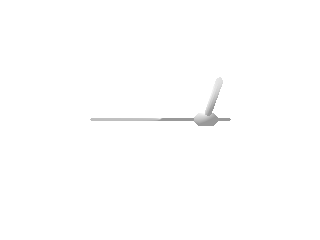

In [ ]:
# hide
# slow
import gym
from IPython import display
import PIL.Image
%matplotlib inline

env=gym.make('InvertedPendulumPyBulletEnv-v0')
s=env.reset()

for z in range(5):
    for i in range(0,100,20):
        s=env.reset()
        env.seed(i)
        for _ in range(200):
            display.clear_output(wait=True)
            display.display(PIL.Image.fromarray(env.render(mode='rgb_array')))

            agent.z=z
            a,_=agent(s,None)

            s,r,d,_=env.step(a)
            if d:
                break

In [ ]:
# hide
from nbdev.export import *
from nbdev.export2html import *
notebook2script()
notebook2html()

Converted 00_core.ipynb.
Converted 01_wrappers.ipynb.
Converted 03_basic_agents.ipynb.
Converted 04_learner.ipynb.
Converted 05a_ptan_extend.ipynb.
Converted 05b_data.ipynb.
Converted 05c_async_data.ipynb.
Converted 13_metrics.ipynb.
Converted 14a_actorcritic.sac.ipynb.
Converted 14b_actorcritic.diayn.ipynb.
Converted 14c_actorcritic.dads.ipynb.
Converted 15_actorcritic.a3c_data.ipynb.
Converted 16_actorcritic.a2c.ipynb.
Converted 17_actorcritc.v1.dads.ipynb.
Converted 18_policy_gradient.ppo.ipynb.
Converted 19_policy_gradient.trpo.ipynb.
Converted 20a_qlearning.dqn.ipynb.
Converted 20b_qlearning.dqn_n_step.ipynb.
Converted 20c_qlearning.dqn_target.ipynb.
Converted 20d_qlearning.dqn_double.ipynb.
Converted 20e_qlearning.dqn_noisy.ipynb.
Converted index.ipynb.
Converted notes.ipynb.


converting: /opt/project/fastrl/nbs/14b_actorcritic.diayn.ipynb
